In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import cauchy

In [2]:
# ============================================================
# PARÁMETROS DEL SISTEMA (en mm)
# ============================================================
d = 20.0   # Altura de la fuente
g = 1.0    # Separación fuente-detector
D = 55.0   # Altura del detector
G = 35.0   # Ancho del detector
L = 30.0   # Distancia horizontal

In [3]:
# Datos experimentales de eficiencia vs energía
ENERGIA_KEV = np.array([200, 400, 600, 800, 1000, 1200, 1400])
EFICIENCIA = np.array([0.03722, 0.02078, 0.01478, 0.01160, 0.00962, 0.00825, 0.00725])

# Parámetros del Cs-137
E0_CS137 = 662  # keV
GAMMA_RESOLUCION = 10  # keV (FWHM)
ACTIVIDAD = 300e3  # 300 kBq = 300,000 Bq
TIEMPO_MEDICION = 5 * 60  # 5 minutos en segundos

In [4]:
# ============================================================
# PARTE 1: EFICIENCIA GEOMÉTRICA (MONTE CARLO)
# ============================================================

class SimuladorGeometrico:
    """Simulador Monte Carlo para eficiencia geométrica"""
    
    def __init__(self, d, g, D, G, L):
        self.d = d
        self.g = g
        self.D = D
        self.G = G
        self.L = L
        
        # Posición de la fuente (izquierda, centrada en y=0)
        self.x_fuente = 0
        self.y_fuente_min = -d/2
        self.y_fuente_max = d/2
        
        # Posición del detector (derecha)
        self.x_detector = L + g
        self.y_detector_min = -D/2
        self.y_detector_max = D/2
        self.x_detector_max = self.x_detector + G
    
    def generar_punto_fuente(self):
        """Genera un punto aleatorio dentro de la fuente"""
        x = self.x_fuente
        y = np.random.uniform(self.y_fuente_min, self.y_fuente_max)
        return x, y
    
    def generar_direccion_aleatoria(self):
        """Genera una dirección aleatoria (ángulo entre 0 y 2π)"""
        theta = np.random.uniform(0, 2*np.pi)
        return theta
    
    def rayo_alcanza_detector(self, x0, y0, theta):
        """
        Determina si un rayo desde (x0, y0) con ángulo theta
        atraviesa el volumen del detector
        """
        # Dirección del rayo
        dx = np.cos(theta)
        dy = np.sin(theta)
        
        # Evitar división por cero
        if abs(dx) < 1e-10:
            return False
        
        # Calcular intersecciones con las caras verticales del detector
        # Cara izquierda del detector (x = x_detector)
        t1 = (self.x_detector - x0) / dx
        
        # Cara derecha del detector (x = x_detector_max)
        t2 = (self.x_detector_max - x0) / dx
        
        # Solo considerar intersecciones hacia adelante (t > 0)
        if t1 <= 0 and t2 <= 0:
            return False
        
        # Verificar si el rayo cruza alguna de las caras verticales
        # dentro del rango vertical del detector
        for t in [t1, t2]:
            if t > 0:
                y_intersect = y0 + t * dy
                if self.y_detector_min <= y_intersect <= self.y_detector_max:
                    return True
        
        return False
    
    def simular(self, n_rayos=1000000):
        """
        Simula n_rayos y calcula la eficiencia geométrica
        """
        detecciones = 0
        
        for i in range(n_rayos):
            # Generar punto de emisión
            x0, y0 = self.generar_punto_fuente()
            
            # Generar dirección aleatoria
            theta = self.generar_direccion_aleatoria()
            
            # Verificar si alcanza el detector
            if self.rayo_alcanza_detector(x0, y0, theta):
                detecciones += 1
        
        # Calcular eficiencia geométrica
        eficiencia_geom = detecciones / n_rayos
        
        # Calcular incerteza (binomial)
        incerteza = np.sqrt(eficiencia_geom * (1 - eficiencia_geom) / n_rayos)
        
        return eficiencia_geom, incerteza, detecciones, n_rayos

In [5]:
# ============================================================
# PARTE 2: EFICIENCIA EN ENERGÍA (INTERPOLACIÓN)
# ============================================================

def crear_funcion_eficiencia_energia():
    """
    Crea una función interpolada para la eficiencia vs energía
    Usa interpolación cúbica (spline)
    """
    # Interpolación cúbica
    f_eficiencia = interp1d(ENERGIA_KEV, EFICIENCIA, kind='cubic', 
                            fill_value='extrapolate')
    return f_eficiencia

def graficar_eficiencia_energia(f_eficiencia):
    """Grafica la curva de eficiencia vs energía"""
    E_plot = np.linspace(200, 1400, 500)
    eff_plot = f_eficiencia(E_plot)
    
    plt.figure(figsize=(10, 6))
    plt.plot(E_plot, eff_plot, 'b-', label='Interpolación cúbica', linewidth=2)
    plt.plot(ENERGIA_KEV, EFICIENCIA, 'ro', markersize=8, label='Datos experimentales')
    plt.xlabel('Energía (keV)', fontsize=12)
    plt.ylabel('Eficiencia en energía ε(E)', fontsize=12)
    plt.title('Eficiencia en Energía del Detector', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

In [6]:
# ============================================================
# PARTE 3: ESPECTRO SIMULADO PARA Cs-137
# ============================================================

def simular_espectro_cs137(eficiencia_geom, f_eficiencia, n_bins=100):
    """
    Simula el espectro de salida del detector para una fuente de Cs-137
    
    Args:
        eficiencia_geom: Eficiencia geométrica calculada
        f_eficiencia: Función de eficiencia en energía
        n_bins: Número de bins para el histograma
    """
    # Número de fotones emitidos por la fuente
    N_fotones_emitidos = ACTIVIDAD * TIEMPO_MEDICION
    
    # Número de fotones que alcanzan el detector (geometría)
    N_fotones_geometricos = int(N_fotones_emitidos * eficiencia_geom)
    
    # Eficiencia en energía para 662 keV
    eff_energia_662 = f_eficiencia(E0_CS137)
    
    # Eficiencia total
    eficiencia_total = eficiencia_geom * eff_energia_662
    
    # Número de fotones detectados
    N_detectados = int(N_fotones_emitidos * eficiencia_total)
    
    print(f"\n{'='*60}")
    print(f"SIMULACIÓN ESPECTRO Cs-137")
    print(f"{'='*60}")
    print(f"Fotones emitidos (5 min):        {N_fotones_emitidos:.2e}")
    print(f"Pasan por detector (geom):       {N_fotones_geometricos:.2e}")
    print(f"Eficiencia en 662 keV:           {eff_energia_662:.6f}")
    print(f"Eficiencia total:                {eficiencia_total:.6f}")
    print(f"Fotones detectados (esperados):  {N_detectados:.2e}")
    print(f"{'='*60}\n")
    
    # Generar energías detectadas con distribución de Lorentz
    # En scipy, la distribución de Cauchy es equivalente a Lorentz
    # loc = E0 (pico), scale = Γ/2 (para Cauchy)
    energias_detectadas = cauchy.rvs(loc=E0_CS137, scale=GAMMA_RESOLUCION/2, 
                                     size=N_detectados)
    
    # Graficar histograma
    plt.figure(figsize=(12, 7))
    
    # Crear histograma
    counts, bins, patches = plt.hist(energias_detectadas, bins=n_bins, 
                                     range=(E0_CS137-100, E0_CS137+100),
                                     color='skyblue', edgecolor='black', 
                                     alpha=0.7, label='Espectro simulado')
    
    # Línea vertical en E0
    plt.axvline(E0_CS137, color='red', linestyle='--', linewidth=2, 
                label=f'E₀ = {E0_CS137} keV')
    
    plt.xlabel('Energía (keV)', fontsize=12)
    plt.ylabel('Cuentas', fontsize=12)
    plt.title(f'Espectro Simulado - ¹³⁷Cs (5 minutos)\n' + 
              f'Actividad: {ACTIVIDAD/1000:.0f} kBq | ' +
              f'Resolución: {GAMMA_RESOLUCION} keV FWHM',
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    return energias_detectadas, N_detectados

In [7]:
# ============================================================
# FUNCIÓN PRINCIPAL - EJECUTAR TODO EL PROYECTO
# ============================================================

def ejecutar_proyecto_completo():
    """Ejecuta todas las partes del proyecto"""
    
    print("\n" + "="*70)
    print("PROYECTO FINAL - FÍSICA COMPUTACIONAL")
    print("Simulación Monte Carlo de Detector Gamma")
    print("="*70)
    
    # ========================================
    # PARTE 1: EFICIENCIA GEOMÉTRICA
    # ========================================
    print("\n[1/4] Calculando eficiencia geométrica...")
    
    simulador = SimuladorGeometrico(d, g, D, G, L)
    eficiencia_geom, incerteza_geom, detecciones, total = simulador.simular(n_rayos=1000000)
    
    print(f"\n{'='*60}")
    print(f"RESULTADOS - EFICIENCIA GEOMÉTRICA")
    print(f"{'='*60}")
    print(f"Rayos simulados:       {total:,}")
    print(f"Rayos detectados:      {detecciones:,}")
    print(f"Eficiencia geométrica: {eficiencia_geom:.6f} ± {incerteza_geom:.6f}")
    print(f"Porcentaje:            {eficiencia_geom*100:.4f}%")
    print(f"{'='*60}\n")
    
    # ========================================
    # PARTE 2: EFICIENCIA EN ENERGÍA
    # ========================================
    print("[2/4] Creando función de eficiencia en energía...")
    
    f_eficiencia = crear_funcion_eficiencia_energia()
    
    print("\n[3/4] Graficando eficiencia en energía...")
    graficar_eficiencia_energia(f_eficiencia)
    
    # Evaluar en 662 keV
    eff_662 = f_eficiencia(E0_CS137)
    print(f"\nEficiencia en 662 keV: {eff_662:.6f}")
    
    # Eficiencia total
    eficiencia_total = eficiencia_geom * eff_662
    print(f"Eficiencia total en 662 keV: {eficiencia_total:.6f}")
    
    # ========================================
    # PARTE 3: ESPECTRO Cs-137
    # ========================================
    print("\n[4/4] Simulando espectro de Cs-137...")
    
    energias, n_det = simular_espectro_cs137(eficiencia_geom, f_eficiencia, n_bins=80)
    
    # ========================================
    # RESUMEN FINAL
    # ========================================
    print("\n" + "="*70)
    print("RESUMEN DE RESULTADOS")
    print("="*70)
    print(f"\n1. Eficiencia Geométrica:")
    print(f"   εg = {eficiencia_geom:.6f} ± {incerteza_geom:.6f}")
    print(f"\n2. Eficiencia en Energía (662 keV):")
    print(f"   ε(662 keV) = {eff_662:.6f}")
    print(f"\n3. Eficiencia Total (662 keV):")
    print(f"   εT = εg × ε(E) = {eficiencia_total:.6f}")
    print(f"\n4. Espectro Cs-137 (5 minutos):")
    print(f"   Fotones detectados: {n_det:,}")
    print(f"   Energía media: {np.mean(energias):.2f} keV")
    print(f"   Desviación estándar: {np.std(energias):.2f} keV")
    print("\n" + "="*70)
    
    return {
        'eficiencia_geometrica': eficiencia_geom,
        'incerteza_geometrica': incerteza_geom,
        'eficiencia_energia_662': eff_662,
        'eficiencia_total': eficiencia_total,
        'espectro': energias,
        'n_detectados': n_det
    }


PROYECTO FINAL - FÍSICA COMPUTACIONAL
Simulación Monte Carlo de Detector Gamma

[1/4] Calculando eficiencia geométrica...

RESULTADOS - EFICIENCIA GEOMÉTRICA
Rayos simulados:       1,000,000
Rayos detectados:      228,389
Eficiencia geométrica: 0.228389 ± 0.000420
Porcentaje:            22.8389%

[2/4] Creando función de eficiencia en energía...

[3/4] Graficando eficiencia en energía...


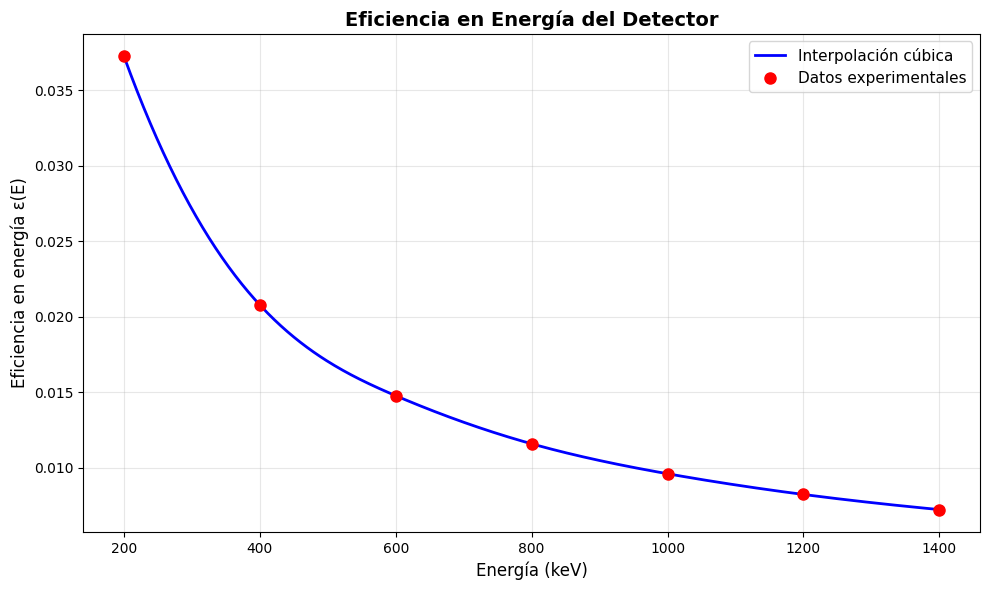


Eficiencia en 662 keV: 0.013654
Eficiencia total en 662 keV: 0.003118

[4/4] Simulando espectro de Cs-137...

SIMULACIÓN ESPECTRO Cs-137
Fotones emitidos (5 min):        9.00e+07
Pasan por detector (geom):       2.06e+07
Eficiencia en 662 keV:           0.013654
Eficiencia total:                0.003118
Fotones detectados (esperados):  2.81e+05



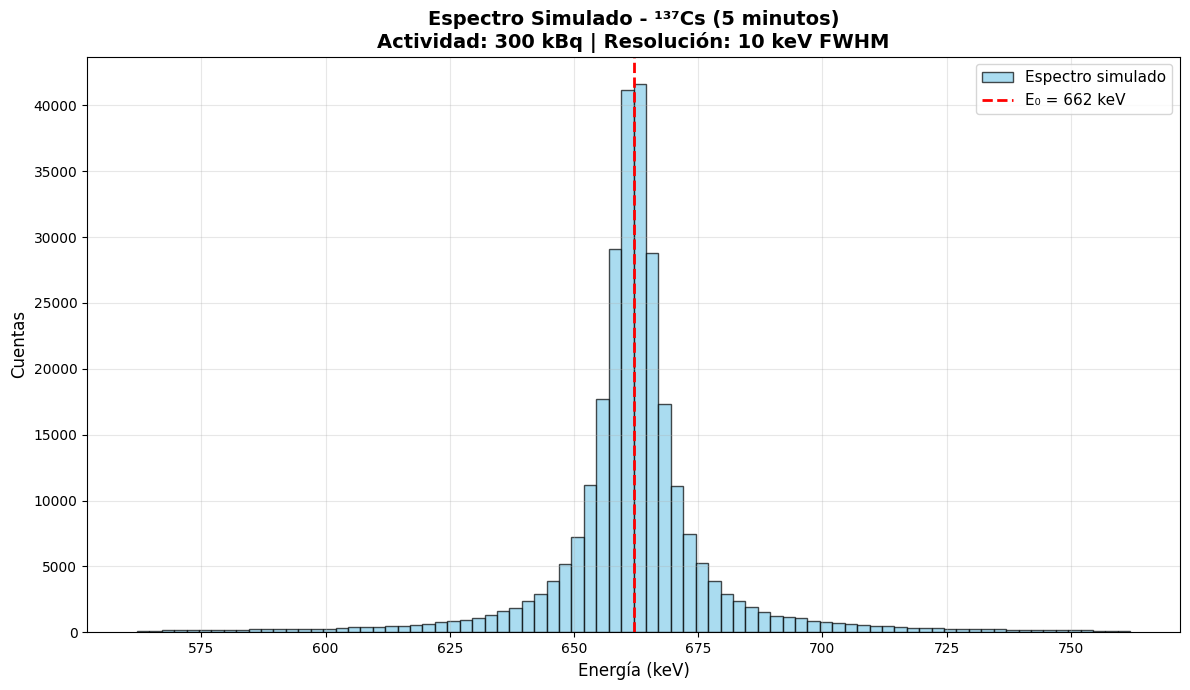


RESUMEN DE RESULTADOS

1. Eficiencia Geométrica:
   εg = 0.228389 ± 0.000420

2. Eficiencia en Energía (662 keV):
   ε(662 keV) = 0.013654

3. Eficiencia Total (662 keV):
   εT = εg × ε(E) = 0.003118

4. Espectro Cs-137 (5 minutos):
   Fotones detectados: 280,649
   Energía media: 655.83 keV
   Desviación estándar: 2771.13 keV



In [8]:
# ============================================================
# EJECUCIÓN
# ============================================================

if __name__ == "__main__":
    resultados = ejecutar_proyecto_completo()

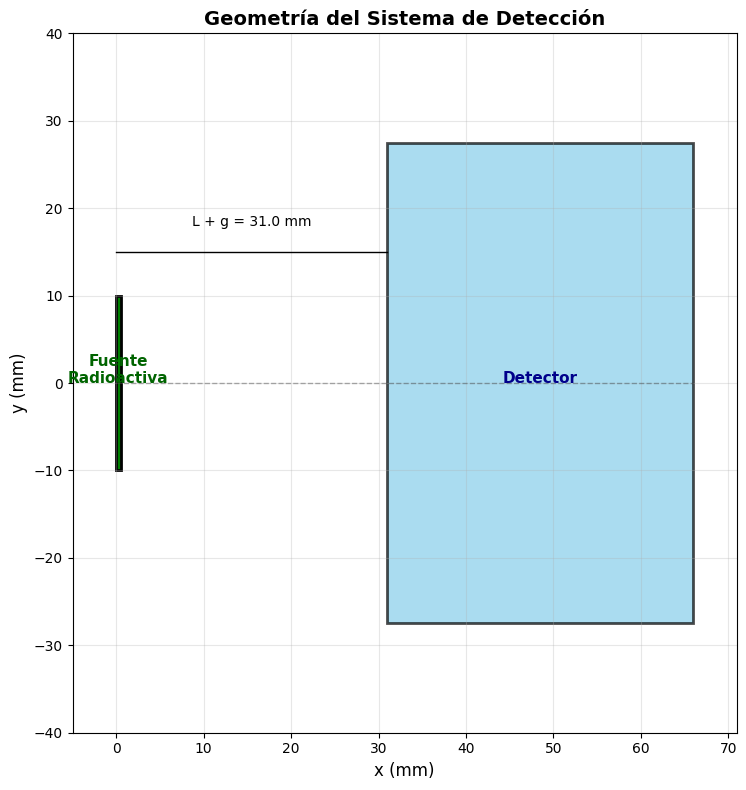

In [9]:
# Función para visualizar la geometría
def visualizar_geometria():
    """Dibuja el sistema detector-fuente"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Fuente (verde)
    fuente = plt.Rectangle((0, -d/2), 0.5, d, 
                           facecolor='green', edgecolor='black', linewidth=2)
    ax.add_patch(fuente)
    
    # Detector (azul)
    detector = plt.Rectangle((L+g, -D/2), G, D, 
                             facecolor='skyblue', edgecolor='black', 
                             linewidth=2, alpha=0.7)
    ax.add_patch(detector)
    
    # Eje central
    ax.plot([0, L+g+G], [0, 0], 'k--', alpha=0.3, linewidth=1)
    
    # Anotaciones
    ax.annotate('Fuente\nRadioactiva', xy=(0.25, 0), fontsize=11, 
                ha='center', fontweight='bold', color='darkgreen')
    ax.annotate('Detector', xy=(L+g+G/2, 0), fontsize=11, 
                ha='center', fontweight='bold', color='darkblue')
    
    # Dimensiones
    ax.plot([0, L+g], [d/2+5, d/2+5], 'k-', linewidth=1)
    ax.text((L+g)/2, d/2+8, f'L + g = {L+g:.1f} mm', 
            ha='center', fontsize=10)
    
    ax.set_xlim(-5, L+g+G+5)
    ax.set_ylim(-40, 40)
    ax.set_aspect('equal')
    ax.set_xlabel('x (mm)', fontsize=12)
    ax.set_ylabel('y (mm)', fontsize=12)
    ax.set_title('Geometría del Sistema de Detección', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Llamar para visualizar
visualizar_geometria()